# Trabalho Prático 02 - IA_24/25

## Autores:
- Nuno Castro_4944  
- Jorge Mendes_18466  
- André Freitas_25975  

### Janeiro 2025


## Introdução
A aplicação de técnicas de aprendizagem máquina e análise de dados em problemas práticos requer uma abordagem estruturada e bem planeada. Neste trabalho, exploraremos três temas principais: Classificação Automática, Agrupamento (Clustering) e Regras de Associação. Estes tópicos cobrem uma ampla gama de aplicações no campo da Inteligência Artificial e fornecem ferramentas fundamentais para analisar, prever e descobrir padrões em dados.

***



### Análise de Regras de Associação com o Algoritmo Apriori

Este projeto utiliza o algoritmo Apriori para identificar padrões ocultos e associações frequentes entre características de imóveis no dataset. A análise de regras de associação permite explorar relações do tipo "SE X, ENTÃO Y" entre atributos, como áreas, número de quartos e preços, ajudando a compreender como diferentes características se relacionam entre si. Este tipo de análise é especialmente útil em contextos como o mercado imobiliário, onde a identificação de combinações de atributos frequentemente associados pode auxiliar na definição de estratégias de marketing, preços ou recomendações personalizadas para potenciais compradores.

## 1.  Seleção de dados

### 1.1  Download do Dataset

Origem: https://www.kaggle.com/datasets/jaynadkarni/housing-dataset

In [1]:
# Download dataset from Kaggle
import kagglehub

dataset_path = "jaynadkarni/housing-dataset"
!kaggle datasets download {dataset_path} -p /content/ --unzip

import os

# Listar ficheiros disponíveis no diretório
print("Ficheiros disponíveis no diretório:")
print(os.listdir("/content/"))

# Verificar se o ficheiro existe
if os.path.exists("/content/Housing.csv"):
    print("O ficheiro foi encontrado!")
else:
    print("O ficheiro Housing.csv não foi encontrado. Verifique o processo de download.")


Dataset URL: https://www.kaggle.com/datasets/jaynadkarni/housing-dataset
License(s): apache-2.0
  0% 0.00/4.63k [00:00<?, ?B/s]
100% 4.63k/4.63k [00:00<00:00, 6.81MB/s]
Ficheiros disponíveis no diretório:
['.config', 'Housing.csv', 'sample_data']
O ficheiro foi encontrado!


### 1.2 Apresentação do Conteudo do ficheiro

In [2]:
#Instalação de bibliotecas
!pip install apyori

# Imports
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


# Read the file
path = "/content/Housing.csv"
dados = pd.read_csv(path)
# Print head
dados.tail()


  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5954 sha256=8a3ef7b969cd15b3df4fec38a5531cc5e31d838ac68400027e09b85daa743d6b
  Stored in directory: /root/.cache/pip/wheels/c4/1a/79/20f55c470a50bb3702a8cb7c94d8ada15573538c7f4baebe2d
Successfully built apyori


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished
544,1750000,3850,3,1,2,yes,no,no,no,no,0,no,unfurnished


###  2  Verificação e Tratamento de Dados

Nesta etapa, verificamos valores ausentes e tratamos variáveis categóricas e booleanas, convertendo-as em valores numéricos. Isso é necessário para preparar os dados para as regras de associação.

In [3]:
# 1. Eliminar registos com valores nulos
dados.dropna(inplace=True)

# 3. Transformar variáveis booleanas/categóricas em valores numéricos
boolean_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning']
dados[boolean_columns] = dados[boolean_columns].replace({'yes': 1, 'no': 0})




<ipython-input-3-8d2ab1d62fd6>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dados[boolean_columns] = dados[boolean_columns].replace({'yes': 1, 'no': 0})


Verificação dos dados

In [4]:
print(dados.head())

      price  area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  13300000  7420         4          2        3         1          0   
1  12250000  8960         4          4        4         1          0   
2  12250000  9960         3          2        2         1          0   
3  12215000  7500         4          2        2         1          0   
4  11410000  7420         4          1        2         1          1   

   basement  hotwaterheating  airconditioning  parking prefarea  \
0         0                0                1        2      yes   
1         0                0                1        3       no   
2         1                0                0        2      yes   
3         1                0                1        3      yes   
4         1                0                1        2       no   

  furnishingstatus  
0        furnished  
1        furnished  
2   semi-furnished  
3        furnished  
4        furnished  


In [5]:
dados = dados.drop(['prefarea', 'parking','price'], axis=1)

### 2.1 Discretizar a Colunas
Convertemos a coluna área em categorias para facilitar a análise de associações.

**Nota:**  A função `pd.cut` divide os dados de uma variável em intervalos com base no menor e no maior valor da coluna

In [6]:
# Discretizar a coluna `area` em categorias
dados['area'] = pd.cut(
    dados['area'],
    bins=4,
    labels=['area_pequena', 'area_media', 'area_grande', 'area_muito_grande']
    )
print(dados['area'].value_counts())

area
area_pequena         318
area_media           197
area_grande           24
area_muito_grande      6
Name: count, dtype: int64


In [7]:
# Discretizar a coluna 'bedrooms'
dados['bedrooms'] = pd.cut(dados['bedrooms'], bins=[0, 2, 4, 6], labels=['1-2_quartos', '3-4_quartos', '5_ou_mais_quartos'])


In [8]:
# Discretizar a coluna 'bathrooms'
dados['bathrooms'] = pd.cut(dados['bathrooms'], bins=[0, 1, 2, 3], labels=['1_wc', '2_wc', '3_wc'])


In [9]:
# Discretizar a coluna 'stories'
dados['stories'] = pd.cut(dados['stories'], bins=[0, 1, 2], labels=['1_andar', '2_ou_mais_andares'])

Conversão de variáveis categóricas em variáveis binárias, para podermos aplicar o algoritmo **Apriori**




In [10]:
# Aplicando one-hot encoding na coluna 'furnishingstatus' com prefixo
dados = pd.get_dummies(dados, columns=['furnishingstatus'], prefix='furnishingstatus', drop_first=True)


In [11]:
# Agora, a transformação do dataframe pode ser feita para o Apriori
dados_dummies = pd.get_dummies(dados)

print(dados_dummies.head())

   mainroad  guestroom  basement  hotwaterheating  airconditioning  \
0         1          0         0                0                1   
1         1          0         0                0                1   
2         1          0         1                0                0   
3         1          0         1                0                1   
4         1          1         1                0                1   

   furnishingstatus_semi-furnished  furnishingstatus_unfurnished  \
0                            False                         False   
1                            False                         False   
2                             True                         False   
3                            False                         False   
4                            False                         False   

   area_area_pequena  area_area_media  area_area_grande  \
0              False             True             False   
1              False            False              T

### 3. Algortitmo Apriori



Este código transforma o conjunto de dados em um formato binário adequado para aplicação do algoritmo Apriori. A descrição detalhada:

1. **One-Hot Encoding:** Converte as colunas categóricas do dataset original em colunas binárias, onde cada valor categórico único se torna uma nova coluna.
2. **Forçar valores binários:** Garante que todos os valores no dataset sejam estritamente 0 ou 1, aplicando uma função que transforma qualquer valor maior que 0 em 1.
3. **Verificação:** Exibe as primeiras linhas do dataset processado para confirmar que a transformação foi realizada corretamente.
Este passo é essencial para preparar os dados para a mineração de padrões frequentes, uma vez que o algoritmo Apriori requer dados binários (presença ou ausência de características).








In [12]:
dados_dummies = pd.get_dummies(dados)
dados_dummies = dados_dummies.astype(int)

# Garantir que todos os valores sejam 0 ou 1
dados_dummies = dados_dummies.applymap(lambda x: 1 if x > 0 else 0)

# Verificar se os dados estão binários
print(dados_dummies.head())

   mainroad  guestroom  basement  hotwaterheating  airconditioning  \
0         1          0         0                0                1   
1         1          0         0                0                1   
2         1          0         1                0                0   
3         1          0         1                0                1   
4         1          1         1                0                1   

   furnishingstatus_semi-furnished  furnishingstatus_unfurnished  \
0                                0                             0   
1                                0                             0   
2                                1                             0   
3                                0                             0   
4                                0                             0   

   area_area_pequena  area_area_media  area_area_grande  \
0                  0                1                 0   
1                  0                0               

<ipython-input-12-71bb0e98abb6>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dados_dummies = dados_dummies.applymap(lambda x: 1 if x > 0 else 0)


####3.1 Identificação de Conjuntos Frequentes e Geração de Regras de Associação

Este código aplica o algoritmo Apriori para identificar conjuntos frequentes de itens e gerar regras de associação a partir deles:

1. **Conjuntos frequentes:** Utiliza a função apriori para identificar combinações de itens com um suporte mínimo de 20%, ou seja, combinações que aparecem em pelo menos 20% dos registos.
2. **Regras de associação:** Com base nos conjuntos frequentes, a função association_rules gera regras que atendem ao critério de lift (relevância) com um mínimo de 1.0.

O objetivo é descobrir padrões úteis e relações significativas nos dados, como itens que frequentemente ocorrem juntos.

In [13]:
from mlxtend.frequent_patterns import apriori, association_rules

# Encontrar os conjuntos frequentes com um mínimo de suporte de 10%
frequent_itemsets = apriori(dados_dummies, min_support=0.2, use_colnames=True)

# Gerar as regras de associação, passando o num_itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0, num_itemsets=10)

Este código apresenta os resultados obtidos no processo de análise de associação:

1. Exibe os conjuntos frequentes, mostrando os itens mais recorrentes no dataset.
2. Apresenta as regras de associação geradas, indicando os itens consequentes esperados com base nos antecedentes, bem como as métricas de suporte, confiança e lift para avaliar a qualidade das regras.

In [14]:
#Resultados

# Converter o suporte dos conjuntos frequentes para percentagem
frequent_itemsets['support_percentage'] = frequent_itemsets['support'] * 100

# Converter o suporte das regras para percentagem
rules['support_percentage'] = rules['support'] * 100

# Exibir conjuntos frequentes com percentagem
print(frequent_itemsets[['itemsets', 'support_percentage']])

# Exibir regras de associação com percentagem
print(rules[['antecedents', 'consequents', 'support_percentage', 'confidence', 'lift']])

                                             itemsets  support_percentage
0                                          (mainroad)           85.871560
1                                          (basement)           35.045872
2                                   (airconditioning)           31.559633
3                   (furnishingstatus_semi-furnished)           41.651376
4                      (furnishingstatus_unfurnished)           32.660550
..                                                ...                 ...
73  (stories_2_ou_mais_andares, bedrooms_3-4_quart...           26.238532
74  (area_area_pequena, mainroad, bedrooms_3-4_qua...           23.669725
75  (area_area_pequena, mainroad, bedrooms_3-4_qua...           20.917431
76  (mainroad, bedrooms_3-4_quartos, bathrooms_1_w...           21.651376
77  (area_area_pequena, stories_2_ou_mais_andares,...           20.000000

[78 rows x 2 columns]
                                antecedents  \
0                                (basement

####3.2 Visualização dos Conjuntos de Itens Frequentes

Este código identifica e apresenta os 10 conjuntos de itens mais frequentes, com base na percentagem de suporte, através de um gráfico de barras horizontais. Inicialmente, filtra os conjuntos que possuem pelo menos o número especificado de itens (length) e transforma os conjuntos em descrições legíveis. Em seguida, o gráfico exibe os conjuntos ordenados por suporte, permitindo uma análise clara dos padrões mais relevantes no dataset.

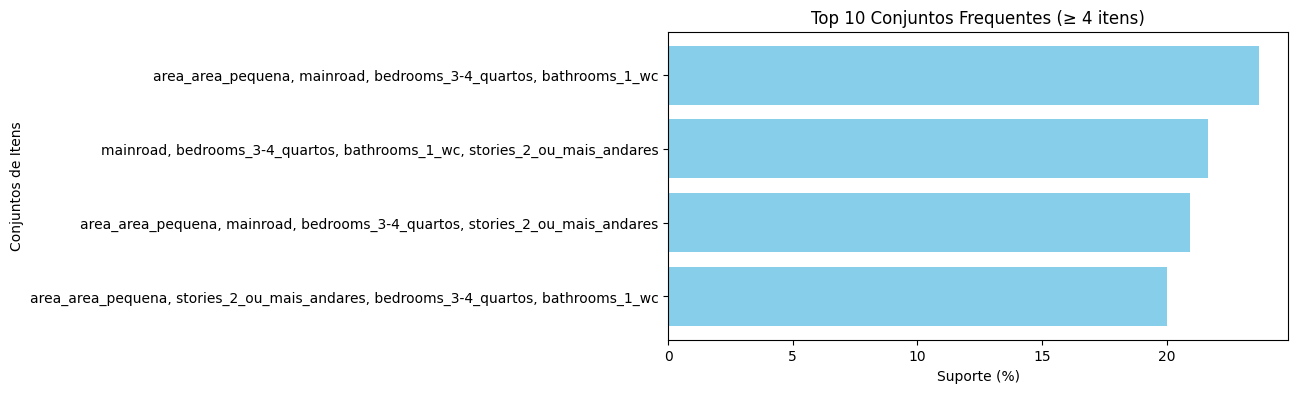

In [17]:
import matplotlib.pyplot as plt

length = 4

# Adicionar uma coluna com o número de itens em cada conjunto
frequent_itemsets['itemset_length'] = frequent_itemsets['itemsets'].apply(len)

# Filtrar apenas conjuntos com pelo menos o tamanho definido
frequent_itemsets_items = frequent_itemsets[frequent_itemsets['itemset_length'] >= length]

# Selecionar os 10 conjuntos mais frequentes
top_frequent_itemsets_items = frequent_itemsets_items.nlargest(10, 'support_percentage')

# Converter os conjuntos para strings legíveis, separados por vírgulas
top_frequent_itemsets_items['itemsets_str'] = top_frequent_itemsets_items['itemsets'].apply(lambda x: ', '.join(x))

# Criar o gráfico
plt.figure(figsize=(8, 4))
plt.barh(
    top_frequent_itemsets_items['itemsets_str'],  # Conjuntos legíveis
    top_frequent_itemsets_items['support_percentage'],
    color='skyblue'
)

# Adicionar rótulos e título
plt.xlabel('Suporte (%)')
plt.ylabel('Conjuntos de Itens')
plt.title(f'Top 10 Conjuntos Frequentes (≥ {length} itens)')

# Inverter o eixo Y para exibir os maiores valores no topo
plt.gca().invert_yaxis()

# Exibir o gráfico
plt.show()


####3.3 Identificação de Conjuntos de Itens com Suporte Elevado

Este código aplica o algoritmo Apriori para identificar conjuntos de itens frequentes com um suporte mínimo de 10%. Em seguida, filtra os conjuntos contendo exatamente um número especificado de itens (length), calculando o suporte desses conjuntos em percentagem. A tabela resultante é formatada, renomeada e ordenada por suporte em ordem decrescente, permitindo visualizar os itens mais frequentes de forma clara e organizada.

In [18]:
import warnings
warnings.filterwarnings('ignore')

length2 = 4

# Aplicar Apriori para encontrar conjuntos frequentes
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(dados_dummies, min_support=0.1, use_colnames=True)

# Filtrar apenas os conjuntos com um único item (C1)
c1_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) == length2]

# Converter o suporte em percentagem
c1_itemsets['support_percentage'] = c1_itemsets['support'] * 100

# Exibir a tabela formatada
c1_table = c1_itemsets[['itemsets', 'support_percentage']]
c1_table.rename(columns={'support_percentage': 'Suporte (%)'}, inplace=True)

# Ordenar o DataFrame em ordem decrescente pelo Suporte (%)
c1_table.sort_values(by='Suporte (%)', ascending=False, inplace=True)

print(c1_table)


                                              itemsets  Suporte (%)
198  (area_area_pequena, mainroad, bedrooms_3-4_qua...    23.669725
208  (mainroad, bedrooms_3-4_quartos, bathrooms_1_w...    21.651376
199  (area_area_pequena, mainroad, bedrooms_3-4_qua...    20.917431
218  (area_area_pequena, stories_2_ou_mais_andares,...    20.000000
201  (area_area_pequena, mainroad, bathrooms_1_wc, ...    18.715596
189  (furnishingstatus_semi-furnished, mainroad, be...    18.532110
206  (bedrooms_1-2_quartos, stories_1_andar, mainro...    16.880734
178  (basement, mainroad, bedrooms_3-4_quartos, bat...    16.330275
200  (stories_1_andar, area_area_pequena, mainroad,...    15.596330
182  (bedrooms_3-4_quartos, mainroad, airconditioni...    15.412844
202  (bathrooms_1_wc, mainroad, bedrooms_3-4_quarto...    15.229358
186  (furnishingstatus_semi-furnished, area_area_pe...    15.229358
190  (furnishingstatus_semi-furnished, mainroad, be...    15.045872
193  (area_area_pequena, furnishingstatus_unfurn

####3.4 Visualização Gráfica de Conjuntos Frequentes por Suporte

Este código cria um gráfico de barras horizontal para visualizar os conjuntos de itens frequentes e seus respetivos suportes, calculados anteriormente. Os conjuntos são apresentados como strings legíveis, com os valores de suporte exibidos no eixo X. O gráfico é ordenado de forma a destacar os conjuntos mais frequentes no topo, permitindo uma interpretação clara da relevância de cada conjunto no dataset.

Itens com suporte alto (ex.: support > 80%):
* características quase universais no dataset.

Itens com suporte médio (ex.: 20% < support < 50%):
* Representam características comuns, mas não universais.

Itens com suporte baixo (ex.: support < 20%):
*  São características mais específicas ou raras.

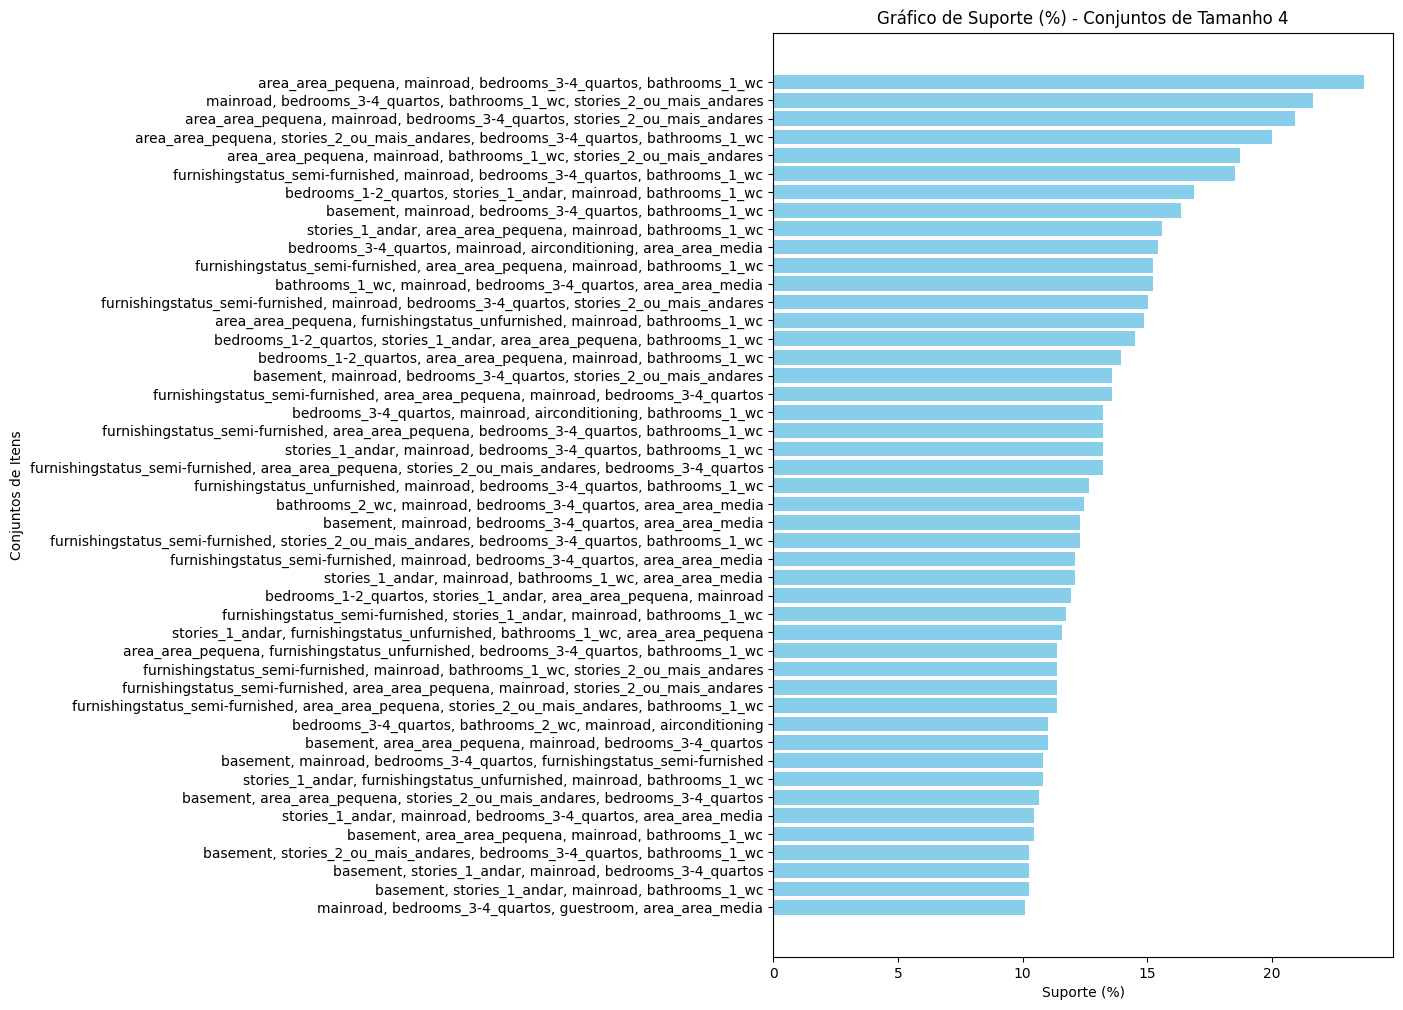

In [19]:
import matplotlib.pyplot as plt

# Ordenar o DataFrame pelo suporte (se ainda não foi feito)
c1_table_sorted = c1_table.sort_values(by='Suporte (%)', ascending=False)

# Converter os conjuntos em strings legíveis (sem frozenset) e separar itens por vírgula
c1_table_sorted['itemsets_str'] = c1_table_sorted['itemsets'].apply(lambda x: ', '.join(x))

# Plotar em barras horizontais
plt.figure(figsize=(8, 12))  # Ajustar o tamanho conforme necessário
plt.barh(
    y=c1_table_sorted['itemsets_str'],  # Itens legíveis como eixo Y
    width=c1_table_sorted['Suporte (%)'],  # Suporte no eixo X
    color='skyblue'
)

# Adicionar rótulos e título
plt.xlabel("Suporte (%)")
plt.ylabel("Conjuntos de Itens")
plt.title(f'Gráfico de Suporte (%) - Conjuntos de Tamanho {length2}')

# Inverter o eixo Y para exibir os maiores valores no topo
plt.gca().invert_yaxis()

# Exibir o gráfico
plt.show()


#### 3.5 Regras de Associação Focadas em 'Área'

Este código aplica o algoritmo Apriori para identificar conjuntos frequentes e regras de associação especificamente relacionadas à variável "area". Primeiramente, são encontrados os conjuntos frequentes com um suporte mínimo, e filtrados aqueles que contêm itens associados a "area". Em seguida, são geradas regras de associação com base em métricas de confiança e lift, destacando regras onde "area" aparece no antecedente. Por fim, as regras relacionadas são exibidas com os valores de suporte, confiança e lift para análise.

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Aplicar Apriori com suporte mínimo ajustado
frequent_itemsets = apriori(dados_dummies, min_support=0.1, use_colnames=True)

# Adicionar o tamanho dos conjuntos
frequent_itemsets['itemset_length'] = frequent_itemsets['itemsets'].apply(len)

# Filtrar conjuntos relacionados a 'area'
area_frequent_itemsets = frequent_itemsets[
    frequent_itemsets['itemsets'].apply(lambda x: any(item.startswith('area') for item in x))
]

# Gerar regras de associação com confiança e lift mínimos ajustados, incluindo num_itemsets
rules = association_rules(
    frequent_itemsets, metric="confidence", min_threshold=0.5, num_itemsets=len(frequent_itemsets)
)

# Filtrar regras relacionadas a 'area' no antecedente
area_related_rules = rules[
    rules['antecedents'].apply(lambda x: any(item.startswith('area') for item in x))
]

# Exibir as regras relacionadas a 'area'
print(area_related_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


                                           antecedents  \
6                                  (area_area_pequena)   
7                                    (area_area_media)   
37                                 (area_area_pequena)   
38                                 (area_area_pequena)   
42                                 (area_area_pequena)   
..                                                 ...   
532  (area_area_pequena, bedrooms_3-4_quartos, bath...   
533  (stories_2_ou_mais_andares, bedrooms_3-4_quart...   
535  (stories_2_ou_mais_andares, mainroad, area_are...   
536  (stories_2_ou_mais_andares, area_area_pequena,...   
538     (stories_2_ou_mais_andares, area_area_pequena)   

                                          consequents   support  confidence  \
6                                          (mainroad)  0.455046    0.779874   
7                                          (mainroad)  0.348624    0.964467   
37                             (bedrooms_3-4_quartos)  0.387156   

####3.6 Análise Estruturada de Regras Relacionadas a 'Área'

Este código organiza e estrutura as regras de associação relacionadas à variável "area". São calculados e adicionados os tamanhos dos antecedentes, consequentes e da regra completa. Os conjuntos de antecedentes e consequentes são convertidos para strings para facilitar a leitura. A tabela final exibe métricas como suporte, confiança e lift, organizadas por tamanho da regra e suporte em ordem decrescente. Este formato melhora a visualização e prioriza regras mais relevantes para análise.

In [ ]:
import pandas as pd

# Copie o DataFrame de regras que você já tem
df_area = area_related_rules.copy()

# Criar colunas para o tamanho do antecedente, consequente e regra total
df_area['antecedent_length'] = df_area['antecedents'].apply(len)
df_area['consequent_length'] = df_area['consequents'].apply(len)
df_area['rule_length'] = df_area['antecedent_length'] + df_area['consequent_length']

# (Opcional) Transformar os conjuntos em strings para exibição
df_area['antecedents_str'] = df_area['antecedents'].apply(lambda x: ", ".join(sorted(x)))
df_area['consequents_str'] = df_area['consequents'].apply(lambda x: ", ".join(sorted(x)))

# Selecionar as colunas de interesse
df_area_tabela = df_area[[
    'rule_length',
    'antecedent_length',
    'consequent_length',
    'antecedents_str',
    'consequents_str',
    'support',
    'confidence',
    'lift'
]]

# Ordenar pelo tamanho total da regra (rule_length) e depois decrescentemente por suporte
df_area_tabela.sort_values(by=['rule_length', 'support'], ascending=[True, False], inplace=True)

# Reseta o índice apenas para organização
df_area_tabela.reset_index(drop=True, inplace=True)

# Exibir a tabela final
df_area_tabela


,rule_length,antecedent_length,consequent_length,antecedents_str,consequents_str,support,confidence,lift
0,2,1,1,area_area_pequena,bathrooms_1_wc,0.480734,0.823899,1.119763
1,2,1,1,area_area_pequena,mainroad,0.455046,0.779874,0.908187
2,2,1,1,area_area_pequena,bedrooms_3-4_quartos,0.387156,0.663522,0.915492
3,2,1,1,area_area_media,mainroad,0.348624,0.964467,1.123151
4,2,1,1,area_area_pequena,stories_2_ou_mais_andares,0.304587,0.522013,1.195365
...,...,...,...,...,...,...,...,...
184,5,4,1,"area_area_pequena, bathrooms_1_wc, bedrooms_3-...",mainroad,0.102752,0.777778,0.905745
185,5,4,1,"area_area_pequena, bathrooms_1_wc, furnishings...",bedrooms_3-4_quartos,0.102752,0.674699,0.930914
186,5,3,2,"area_area_pequena, bedrooms_3-4_quartos, furni...","bathrooms_1_wc, mainroad",0.102752,0.583333,0.935049
187,5,3,2,"area_area_pequena, furnishingstatus_semi-furni...","bathrooms_1_wc, bedrooms_3-4_quartos",0.102752,0.533333,1.092732


#### Interpretação das Regras de Associação Relacionadas à Área

##### Descrição Geral:
Cada linha da tabela pode ser interpretada como:
**“Se temos `antecedents_str` (variáveis X), então frequentemente ocorre `consequents_str` (variáveis Y) com determinada frequência (suporte), probabilidade (confiança) e intensidade de associação (lift).”**

##### Exemplos de Interpretação:
1. **`area_area_pequena => bathrooms_1_wc`**
   - **Suporte (~48%)**: 48% das observações possuem simultaneamente “Área Pequena” e “1 casa de banho”.
   - **Confiança (~82%)**: Em 82% dos imóveis com “Área Pequena”, também ocorre “1 casa de banho”.
   - **Lift (~1,12)**: Indica associação positiva. Ter “Área Pequena” aumenta a probabilidade de ter “1 casa de banho” em comparação com o esperado aleatoriamente.

2. **`area_area_pequena => mainroad`**
   - **Suporte (~45%)**: 45% dos imóveis com “Área Pequena” estão numa via principal.
   - **Confiança (~78%)**: Em 78% dos casos onde há “Área Pequena”, o imóvel também está numa via principal.
   - **Lift (~0,91)**: Apesar da frequência, a associação é ligeiramente negativa, indicando que “Área Pequena” não aumenta a probabilidade de estar numa via principal.

3. **`area_area_media => mainroad`**
   - **Suporte (~35%)**: 35% dos imóveis de área média encontram-se numa via principal.
   - **Confiança (~96%)**: Quase todos os imóveis com “Área Média” estão numa via principal.
   - **Lift (~1,12)**: Existe uma associação positiva significativa.

4. **`area_area_pequena => stories_2_ou_mais_andares`**
   - **Suporte (~30%)**: 30% dos imóveis com “Área Pequena” possuem 2 ou mais andares.
   - **Confiança (~52%)**: Se o imóvel é de “Área Pequena”, há 52% de probabilidade de ter 2 ou mais andares.
   - **Lift (~1,20)**: Forte associação positiva. Pequenas áreas frequentemente possuem mais de um andar.

##### Regras com `rule_length` maior (ex.: 3 ou 4 itens no Antecedente):
- **Suporte Menor (~10%)**: Quanto mais itens no Antecedente, menor a frequência de ocorrência simultânea.
- **Confiança Relevante (>50%)**: Apesar do suporte baixo, uma confiança alta indica que, se todas as condições do Antecedente ocorrem juntas, o Consequente é altamente provável.

##### Conclusões:
- **Área Pequena tende a ter 1 casa de banho**: Alta confiança e suporte, com lift > 1, indicando uma relação clara.
- **Área Média e via principal (mainroad)**: Forte associação com confiança ~96% e lift > 1.
- **Área Pequena + 2 ou mais andares**: Apesar de menos frequente (~30% de suporte), o lift > 1,2 sugere que existe uma correlação positiva (ex.: pequenas casas com mais de um andar).

#### Observações:
- Algumas regras têm **lift < 1** (ex.: `area_area_pequena => mainroad`), indicando que, embora frequentes, não são mais prováveis juntas do que separadamente.
- Regras com suporte baixo e antecedente mais longo oferecem insights específicos, mas aplicam-se a subconjuntos menores de casos.
